In [1]:
import torch
import torch.nn as nn
import timm
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from datasets import load_dataset

c:\Projects\image-captioning-conceptual-captions\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
dataset = load_dataset("conceptual_captions", split="train[:200]")

In [4]:
image = None
caption_text = None

for i in range(len(dataset)):
    sample = dataset[i]
    try:
        image = Image.open(
            requests.get(sample["image_url"], stream=True, timeout=5).raw
        ).convert("RGB")
        caption_text = sample["caption"]
        break
    except:
        continue

image, caption_text

(<PIL.Image.Image image mode=RGB size=500x441>,
 'sierra looked stunning in this top and this skirt while performing with person at their former university')

In [5]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

image_tensor = transform(image).unsqueeze(0).to(device)
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [6]:
vit = timm.create_model("vit_base_patch16_224", pretrained=True)
vit.reset_classifier(0)
vit.eval()
vit.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Projects\image-captioning-conceptual-captions\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jaira\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [7]:
with torch.no_grad():
    features = vit(image_tensor)

features.shape

torch.Size([1, 768])

In [8]:
vocab_size = 1000
caption_tokens = torch.randint(0, vocab_size, (1, 5)).to(device)

In [11]:
class ViTRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, feature_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.fc_image = nn.Linear(feature_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        features = self.fc_image(features)
        features = features.unsqueeze(1)
        inputs = torch.cat((features, embeddings), dim=1)
        outputs, _ = self.rnn(inputs)
        return self.fc(outputs)

In [12]:
model = ViTRNN(
    embed_size=256,
    hidden_size=512,
    vocab_size=vocab_size,
    feature_size=768
).to(device)
outputs = model(features, caption_tokens)
outputs.shape

torch.Size([1, 6, 1000])

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

outputs_for_loss = outputs[:, 1:, :]

loss = criterion(
    outputs_for_loss.reshape(-1, vocab_size),
    caption_tokens.reshape(-1)
)

loss.backward()
optimizer.step()
optimizer.zero_grad()

loss.item()

6.939663887023926

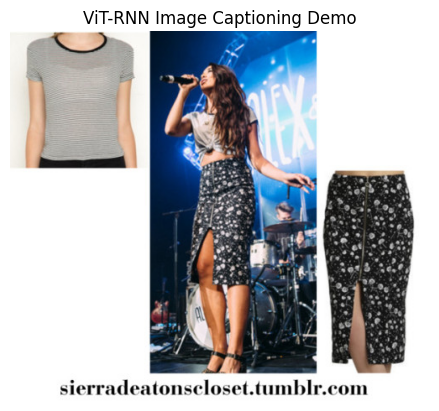

Ground Truth Caption:
sierra looked stunning in this top and this skirt while performing with person at their former university

Generated Output (token-level, illustrative):
[993, 949, 770, 421, 540]


In [15]:
plt.imshow(image)
plt.axis("off")
plt.title("ViT-RNN Image Captioning Demo")
plt.show()

print("Ground Truth Caption:")
print(caption_text)

print("\nGenerated Output (token-level, illustrative):")
print(caption_tokens[0].tolist())